## Implementing softmax regression for the CIFAR-10 dataset
In this assignment, you will implement a multi-class logistic regression, or softmax regression classifier, and apply it to a version of the CIFAR-10 object recognition dataset. This process involves writing vectorized versions of the softmax loss and gradient functions, choosing learning rates and regularization parameters for the optimization algorithm, and visualizing the learned coefficients of the model.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

## Load the CIFAR-10 dataset
Open up a terminal window and navigate to the **datasets** folder inside the  **hw3** folder. Run the
**get\_datasets.sh**  script. On my Mac, I just type in **./get\_datasets.sh** at the shell prompt.
A new folder called **cifar\_10\_batches\_py** will be created and it will contain $50000$ labeled
images for training and $10000$ labeled images for testing. The function further partitions the $50000$ training 
images into a train set and a validation set for selection of hyperparameters. We have provided a function to
read this data in **utils.py**. Each image is a $32 \times 32$ array of RGB triples. It is preprocessed by
subtracting the mean image from all images. We flatten each image into a 1-dimensional array of size
3072 (i.e., $32\times 32 \times 3$). Then a 1 is appended to the front of that vector to handle 
the intercept term.  So the training set is a numpy matrix of size $49000\times 3073$, 
the validation set is a matrix of size $1000\times 3073$ and the set-aside test set 
is of size $10000\times 3073$.

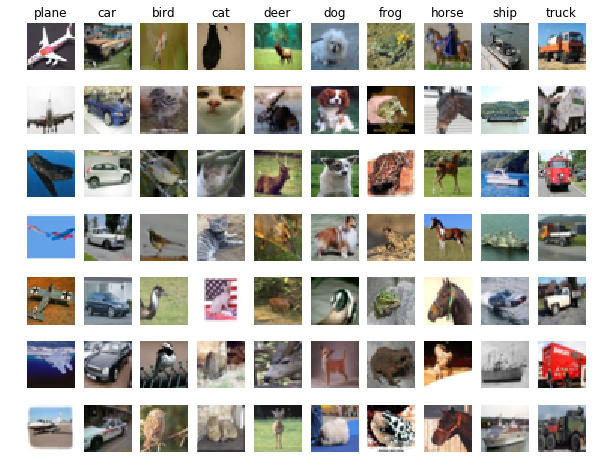

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (10000, 3072)
Training data shape with bias term:  (49000, 3073)
Validation data shape with bias term:  (1000, 3073)
Test data shape with bias term:  (10000, 3073)


In [2]:
import utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_test, y_test = utils.get_CIFAR10_data()

## Implementing the loss function for softmax regression (naive version) 
Softmax regression generalizes logistic regression to classification problems where the class label $y$ can take on more than two possible values. This is useful for such problems as music genre classification and object recognition, where the goal is to distinguish between more than two different music genres or more than two different object categories.  Softmax regression is a supervised learning algorithm, but we will later be using it in conjunction with deep learning and unsupervised feature learning methods.
Recall that we are  given a data set 
$${\cal D} = \{(x^{(i)},y^{(i)}) | 1 \leq i \leq m; x^{(i)} \in \Re^{d+1}; {x_0}^{(i)} = 1, y^{(i)} \in \{1,\ldots, K\}\}, K>2 $$
Our probabilistic model $h_\theta(x)$ is defined as
\begin{eqnarray*}
 h_\theta(x) & = & 
 \left [ \begin{array}{l}
 P(y = 1|x; \theta) \\
 P(y = 2| x; \theta) \\
 \ldots \\
 P(y=K|x;\theta)
 \end{array} \right ]
 \end{eqnarray*}
 where 
 $$ P(y=k|x; \theta) = \frac{exp({\theta^{(k)}}^T x)} {\sum_{j=1}^{K} exp({\theta^{(j)}}^T x)} $$

The parameter  $\theta$ is a $(d+1)\times K$ matrix, where each column represents the parameter vector for class $k = 1,\ldots,K$.
$$\theta = \left [ \begin{array}{llll}
| & | & \ldots & | \\
| & | & \ldots & | \\
\theta^{(1)} & \theta^{(2)} & \ldots & \theta^{(K)} \\
|&  | & \ldots & | \\
| & | & \ldots  &| \\
\end{array}
\right ] $$

Numerical stability issues can come up in the computation of $P(y=k|x;\theta)$. Consider K=3, and $\theta^T x = [123, 456, 789]$. To compute $P(y=k|x;\theta)$ from these scores, we need to calculate $exp(123)$, $exp(456)$ and $exp(789)$, and sum them. These are very large numbers. However, we can get the same probabilities by subtracting the maximum ($789$) from  every element in $\theta^Tx$. Then we have the vector
$[-666,-333,0]$, and we can calculate $exp(-666)$, $exp(-333)$ and $exp(0)$, sum them (call the sum $S$) and then calculate $exp(-666)/S$, $exp(-333/S)$ and $exp(0)/S$.
 
The cost function $J(\theta)$ for softmax regression is derived from the negative log likelihood of the data ${\cal D}$, assuming that  $P(y|x;\theta) = h_\theta(x)$ as defined above.

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^{m} \sum_{k=1}^{K} I\{y^{(i)} = k\} log \frac{exp({\theta^{(k)}}^T x^{(i)})}{\sum_{j=1}^{K} exp({\theta^{(j)}}^T x^{(i)})}  + \frac{\lambda}{2m} \sum_{j=0}^{d}\sum_{k=1}^{K} {{\theta_j}^{(k)}}^2 $$

where $I\{c\}$ is the indicator function which evaluates to 1 when $c$ is a true statement and to $0$ otherwise. The second term is a regularization term, where $\lambda$ is the regularization strength. While it is customary to exclude the bias term in L2 regularization, we include it here because it does not make a huge difference in the final result. You can check this for yourself on the CIFAR-10 dataset. You should implement this loss function using **for** loops for the summations in the function **softmax\_loss\_naive** in **softmax.py**. Once you have the loss function implemented, the cell below will run your loss function for a randomly initialized $\theta$ matrix with 49000 training images and labels with $\lambda$ set to 0. You should expect to see a value of about $-log_e(0.1)$ (Why?).

In [3]:
from softmax import softmax_loss_naive, softmax_loss_vectorized

# First implement the naive softmax loss function with nested loops.
# Open the file softmax.py and implement the
# softmax_loss_naive function.

# Generate a random softmax theta matrix and use it to compute the loss.

theta = np.random.randn(3073,10) * 0.0001
loss, grad = softmax_loss_naive(theta, X_train, y_train, 0.0)

# Loss should be something close to 2.38

print 'loss: (should be close to 2.38): ', loss

loss: (should be close to 2.38):  2.33474745394


## Implementing the gradient of loss function for softmax regression (naive version) 
The derivative of the loss function $J(\theta)$ with respect to the $\theta^{(k)}$ is

$$ \nabla_{\theta^{(k)}} J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} [x^{(i)} (1\{y^{(i)}=k\} - P(y^{(i)}=k|x^{(i)};\theta))] +\frac{\lambda}{m} \theta^{(k)}$$

Implement the analytical derivative computation in **softmax\_loss\_naive** in **softmax.py**.

We  check your implementation of the gradient using the method of finite differences. The functions in ** gradient\_check.py** compute the numerical gradient of a function $f$ as follows:
$$ \frac{\partial f(x)}{\partial x} = \frac{f(x+h)-f(x-h)}{2h} $$
for a very small $h$. The cell below will check your gradient against the numerically approximated gradient -- you should expect to see differences between the two gradients of the order of $10^{-7}$ or less. 


In [5]:
import time
# Open the file softmax.py and implement the gradient in the
# softmax_loss_naive function.

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient. (within 1e-7)

from gradient_check import grad_check_sparse
f = lambda th: softmax_loss_naive(th, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, theta, grad, 10)

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(theta, X_train, y_train, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

numerical: 1.221159 analytic: 1.218896, relative error: 9.273037e-04
numerical: 1.306427 analytic: 1.306496, relative error: 2.674223e-05
numerical: 0.912997 analytic: 0.913026, relative error: 1.581814e-05
numerical: 0.342380 analytic: 0.342531, relative error: 2.192643e-04
numerical: 0.330253 analytic: 0.330080, relative error: 2.619207e-04
numerical: -1.331162 analytic: -1.331166, relative error: 1.440432e-06
numerical: 2.695069 analytic: 2.695105, relative error: 6.815681e-06
numerical: -1.735123 analytic: -1.735064, relative error: 1.692021e-05
numerical: -0.756703 analytic: -0.756593, relative error: 7.285018e-05
numerical: -0.832263 analytic: -0.832223, relative error: 2.430397e-05
naive loss: 2.334769e+00 computed in 15.880287s


## Implementing the loss function and its gradient for softmax regression (vectorized version) 
Now complete the function **softmax\_loss\_vectorized** in **softmax.py** to implement the loss function $J(\theta)$ without using any **for** loops. Re-express the computation in terms of matrix operations on $X$, $y$ and $\theta$. 
Now vectorize the gradient computation in **softmax\_loss\_vectorized** in **softmax.py**. Once you complete this, the cell below will run and time your naive and vectorized implementations -- you should expect to see at least one order of magnitude difference in run time between the two implementations. 

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
from softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(theta, X_train, y_train, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# We use the Frobenius norm to compare the two versions
# of the gradient.

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

vectorized loss: 2.334769e+00 computed in 0.423817s
Loss difference: 0.000000
Gradient difference: 0.000000


## Implementing mini-batch gradient descent 
In large-scale applications, the training data can have millions of examples. Hence, it seems wasteful to compute the  loss function over the entire training set in order to perform only a single parameter update. A very common approach to addressing this challenge is to compute the gradient over batches of the training data. For example, a typical batch contains 256 examples from a training set of over 1.2 million. This batch is then used to perform a parameter update:
$$ \theta^{(k)} \to \theta^{(k)} - \alpha \nabla_{\theta^{(k)}} J(\theta) $$
where $\alpha$ is the step size or learning rate for gradient descent.

Implement mini-batch gradient descent in the method **train** in **linear_classifier.py** using the description provided in the documentation of the method. You can set the **verbose** argument of **train** to be **True** and observe how the loss function varies with iteration number.

You will test your implementation of mini-batch gradient descent in the search for hyperparameters below.

## Using a validation set to select regularization lambda and learning rate for   gradient descent
There are many hyper parameters to be selected for mini batch gradient descent -- the batch size, the number of iterations, and the learning rate. For the loss function, we also need to select $\lambda$, the regularization strength. In this exercise, we have pre-selected a batch size of 400 and an iteration count of 4000. Now, use the validation set provided to sweep the learning rate and the $\lambda$ parameter space, using the suggested values in the cell below to find the best combination of these two hyper parameters. Fill in the code to do this in the section marked **TODO** below.

Once you find the best values of $\lambda$ and learning rate, insert code in the cell below to train a softmax classifier on the training data with the best hyper parameters and save this classifier in the variable  **best\_softmax**.  

In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set and the test set.

import linear_classifier

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [5e4, 1e5, 5e5, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in variable best_softmax.            #
################################################################################

for rate in learning_rates:
    
    for reg in regularization_strengths:
        
        lc_softmax = linear_classifier.LinearClassifier()
        
        lc_softmax.train(X_train, y_train, learning_rate = rate, reg = reg, num_iters = 4000, batch_size = 400, verbose = True)
        
        y_train_pred = lc_softmax.predict(X_train)
        y_val_pred = lc_softmax.predict(X_val)
        
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results.setdefault((rate, reg))
        
        results[(rate, reg)] = train_accuracy, val_accuracy
        
        if val_accuracy > best_val:
        
            best_val = val_accuracy
        
            best_rate, best_reg = rate, reg
            
            best_softmax = lc_softmax

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 4000: loss 7.162824
iteration 100 / 4000: loss 6.105591
iteration 200 / 4000: loss 5.346687
iteration 300 / 4000: loss 5.246232
iteration 400 / 4000: loss 5.096856
iteration 500 / 4000: loss 5.179989
iteration 600 / 4000: loss 4.989866
iteration 700 / 4000: loss 4.780346
iteration 800 / 4000: loss 4.891284
iteration 900 / 4000: loss 4.749408
iteration 1000 / 4000: loss 4.847526
iteration 1100 / 4000: loss 4.581117
iteration 1200 / 4000: loss 4.642771
iteration 1300 / 4000: loss 4.342437
iteration 1400 / 4000: loss 4.398250
iteration 1500 / 4000: loss 4.529234
iteration 1600 / 4000: loss 4.459870
iteration 1700 / 4000: loss 4.316752
iteration 1800 / 4000: loss 4.411841
iteration 1900 / 4000: loss 4.333680
iteration 2000 / 4000: loss 4.374920
iteration 2100 / 4000: loss 4.197515
iteration 2200 / 4000: loss 4.163373
iteration 2300 / 4000: loss 4.200660
iteration 2400 / 4000: loss 4.126181
iteration 2500 / 4000: loss 4.064602
iteration 2600 / 4000: loss 4.057070
iteration 270

iteration 2300 / 4000: loss 4.034591
iteration 2400 / 4000: loss 3.848072
iteration 2500 / 4000: loss 3.804827
iteration 2600 / 4000: loss 3.634982
iteration 2700 / 4000: loss 3.691739
iteration 2800 / 4000: loss 3.626577
iteration 2900 / 4000: loss 3.514516
iteration 3000 / 4000: loss 3.434632
iteration 3100 / 4000: loss 3.387718
iteration 3200 / 4000: loss 3.416200
iteration 3300 / 4000: loss 3.514605
iteration 3400 / 4000: loss 3.255396
iteration 3500 / 4000: loss 3.251812
iteration 3600 / 4000: loss 3.275319
iteration 3700 / 4000: loss 3.132407
iteration 3800 / 4000: loss 3.122646
iteration 3900 / 4000: loss 3.115969
iteration 0 / 4000: loss 24.217674
iteration 100 / 4000: loss 19.803795
iteration 200 / 4000: loss 17.341776
iteration 300 / 4000: loss 15.165756
iteration 400 / 4000: loss 13.474340
iteration 500 / 4000: loss 12.086189
iteration 600 / 4000: loss 10.832207
iteration 700 / 4000: loss 9.714291
iteration 800 / 4000: loss 8.742730
iteration 900 / 4000: loss 7.956209
iterat

iteration 600 / 4000: loss 2.224552
iteration 700 / 4000: loss 2.213644
iteration 800 / 4000: loss 2.212092
iteration 900 / 4000: loss 2.239947
iteration 1000 / 4000: loss 2.228772
iteration 1100 / 4000: loss 2.207157
iteration 1200 / 4000: loss 2.232034
iteration 1300 / 4000: loss 2.212512
iteration 1400 / 4000: loss 2.221774
iteration 1500 / 4000: loss 2.219984
iteration 1600 / 4000: loss 2.206302
iteration 1700 / 4000: loss 2.192977
iteration 1800 / 4000: loss 2.202511
iteration 1900 / 4000: loss 2.209788
iteration 2000 / 4000: loss 2.229208
iteration 2100 / 4000: loss 2.217739
iteration 2200 / 4000: loss 2.220931
iteration 2300 / 4000: loss 2.225555
iteration 2400 / 4000: loss 2.213973
iteration 2500 / 4000: loss 2.211237
iteration 2600 / 4000: loss 2.212177
iteration 2700 / 4000: loss 2.194063
iteration 2800 / 4000: loss 2.225929
iteration 2900 / 4000: loss 2.194267
iteration 3000 / 4000: loss 2.215658
iteration 3100 / 4000: loss 2.201922
iteration 3200 / 4000: loss 2.209049
itera

## Evaluating the best softmax classifier on the test set and visualizing the coefficients
The best\_softmax classifier will be  evaluated on the set aside test set and you should expect to see an overall accuracy of over 35%. 

Compute the confusion matrix (you can use the confusion\_matrix function in **sklearn.metrics** on the test set for your predictor and interpret the visualized coefficients in the light of the errors made by the classifier.

We can remove the bias term from the $\theta$ matrix and reshape each column of the matrix which is a parameter vector of size $3072$ back into an array of size $32\times 32 \times 3$ and visualize the results as an image. The cell below  constructs such a plot, similar to the one in Figure 2 in hw3.pdf. 

softmax on raw pixels final test set accuracy: 0.403200
[[510  50  36  27  13  19  25  38 207  75]
 [ 70 469  18  39  20  34  52  38  97 163]
 [132  48 211  84 118  77 176  62  63  29]
 [ 56  63  79 259  48 162 145  55  55  78]
 [ 66  34 116  67 291  70 194  92  35  35]
 [ 47  42  85 163  68 323 104  66  74  28]
 [ 25  53  58  95  78  64 537  28  22  40]
 [ 63  46  51  52  93  72  66 408  53  96]
 [168  76   8  24   7  48  11  14 546  98]
 [ 81 166  12  26  15  15  45  47 115 478]]


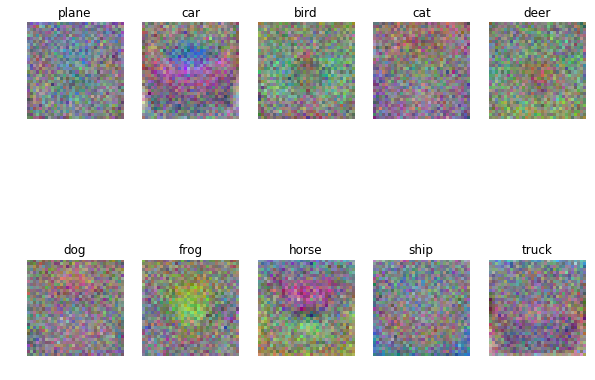

In [9]:
# Evaluate the best softmax classifier on test set

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

# compute confusion matrix
from sklearn.metrics import confusion_matrix
print confusion_matrix(y_test,y_test_pred)

# Visualize the learned weights for each class`

theta = best_softmax.theta[1:,:].T # strip out the bias term
theta = theta.reshape(10, 32, 32, 3)

theta_min, theta_max = np.min(theta), np.max(theta)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

plt.savefig('7.7.png')
plt.show()

## Extra credit:  Experimenting with other hyper parameters and optimization method
We chose a batch size of 400 and 4000 iterations for our previous experiments. Explore larger and smaller batch sizes, choosing an appropriate number of iterations (by specifying a tolerance on differences in values of the loss function or its gradient in successive iterations) with the validation set. Produce plots that show the variation of test set accuracy as a function of batch size/number of iterations. You will have to determine the right settings for regularization strength $\lambda$ and learning rate for each batch size/number of iterations combination. What is the best batch size/number of iterations/learning rate/regularization strength combination for this problem? What is the best test set accuracy that can be achieved by this combination? 

In [27]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set and the test set.

import linear_classifier

results = {}
best_val = -1
best_softmax = None
num_iters = [300, 1000, 3000]
batch_sizes = [100, 300, 1000]
learning_rates = [1e-8, 1e-7, 1e-6]
regularization_strengths = [1e3, 1e5, 1e7]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in variable best_softmax.            #
################################################################################

for rate in learning_rates:
    
    for reg in regularization_strengths:
        
        for iters in num_iters:
            
            for size in batch_sizes:
        
                lc_softmax = linear_classifier.LinearClassifier()
        
                lc_softmax.train(X_train, y_train, learning_rate = rate, reg = reg, num_iters = iters, batch_size = size, verbose = True)
        
                y_train_pred = lc_softmax.predict(X_train)
                y_val_pred = lc_softmax.predict(X_val)
        
                train_accuracy = np.mean(y_train == y_train_pred)
                val_accuracy = np.mean(y_val == y_val_pred)
        
                results.setdefault((rate, reg, iters, size))
        
                results[(rate, reg, iters, size)] = train_accuracy, val_accuracy
        
                if val_accuracy > best_val:
        
                    best_val = val_accuracy
        
                    best_rate, best_reg, best_iters, best_size = rate, reg, iters, size
            
                    best_softmax = lc_softmax

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 300: loss 5.796519
iteration 100 / 300: loss 5.861248
iteration 200 / 300: loss 4.998714
iteration 0 / 300: loss 5.518798
iteration 100 / 300: loss 5.326488
iteration 200 / 300: loss 5.506229
iteration 0 / 300: loss 5.845854
iteration 100 / 300: loss 5.437234
iteration 200 / 300: loss 5.487702
iteration 0 / 1000: loss 5.551672
iteration 100 / 1000: loss 5.197563
iteration 200 / 1000: loss 5.248802
iteration 300 / 1000: loss 4.562209
iteration 400 / 1000: loss 4.477213
iteration 500 / 1000: loss 5.322573
iteration 600 / 1000: loss 4.796909
iteration 700 / 1000: loss 4.809540
iteration 800 / 1000: loss 4.817497
iteration 900 / 1000: loss 3.744715
iteration 0 / 1000: loss 6.695269
iteration 100 / 1000: loss 6.316547
iteration 200 / 1000: loss 5.654307
iteration 300 / 1000: loss 5.356098
iteration 400 / 1000: loss 4.837669
iteration 500 / 1000: loss 4.779812
iteration 600 / 1000: loss 4.570795
iteration 700 / 1000: loss 4.247250
iteration 800 / 1000: loss 4.187645
iteration 9

iteration 2700 / 3000: loss 8.584714
iteration 2800 / 3000: loss 8.481272
iteration 2900 / 3000: loss 8.389874
iteration 0 / 3000: loss 7.131657
iteration 100 / 3000: loss 7.070845
iteration 200 / 3000: loss 6.593623
iteration 300 / 3000: loss 6.578978
iteration 400 / 3000: loss 6.394089
iteration 500 / 3000: loss 6.406829
iteration 600 / 3000: loss 5.949767
iteration 700 / 3000: loss 5.921936
iteration 800 / 3000: loss 5.703391
iteration 900 / 3000: loss 5.638396
iteration 1000 / 3000: loss 5.730107
iteration 1100 / 3000: loss 5.618843
iteration 1200 / 3000: loss 5.513922
iteration 1300 / 3000: loss 5.391995
iteration 1400 / 3000: loss 5.400824
iteration 1500 / 3000: loss 5.221331
iteration 1600 / 3000: loss 5.361766
iteration 1700 / 3000: loss 5.407821
iteration 1800 / 3000: loss 5.311844
iteration 1900 / 3000: loss 5.350819
iteration 2000 / 3000: loss 5.161931
iteration 2100 / 3000: loss 5.181492
iteration 2200 / 3000: loss 5.177242
iteration 2300 / 3000: loss 5.042174
iteration 240

iteration 1900 / 3000: loss 2.672784
iteration 2000 / 3000: loss 2.449927
iteration 2100 / 3000: loss 3.040864
iteration 2200 / 3000: loss 2.810284
iteration 2300 / 3000: loss 2.173132
iteration 2400 / 3000: loss 2.945021
iteration 2500 / 3000: loss 2.477500
iteration 2600 / 3000: loss 2.620695
iteration 2700 / 3000: loss 2.530988
iteration 2800 / 3000: loss 2.641389
iteration 2900 / 3000: loss 2.608151
iteration 0 / 3000: loss 5.629932
iteration 100 / 3000: loss 4.020952
iteration 200 / 3000: loss 3.571979
iteration 300 / 3000: loss 3.328979
iteration 400 / 3000: loss 3.174845
iteration 500 / 3000: loss 3.221703
iteration 600 / 3000: loss 2.908979
iteration 700 / 3000: loss 2.874399
iteration 800 / 3000: loss 2.822751
iteration 900 / 3000: loss 3.037264
iteration 1000 / 3000: loss 2.809391
iteration 1100 / 3000: loss 2.731333
iteration 1200 / 3000: loss 2.659115
iteration 1300 / 3000: loss 2.854692
iteration 1400 / 3000: loss 2.585992
iteration 1500 / 3000: loss 2.890264
iteration 160

iteration 500 / 1000: loss 19.578256
iteration 600 / 1000: loss 11.072291
iteration 700 / 1000: loss 6.677203
iteration 800 / 1000: loss 4.414624
iteration 900 / 1000: loss 3.233981
iteration 0 / 1000: loss 160.220746
iteration 100 / 1000: loss 129.534850
iteration 200 / 1000: loss 105.999169
iteration 300 / 1000: loss 86.985860
iteration 400 / 1000: loss 71.411156
iteration 500 / 1000: loss 58.762753
iteration 600 / 1000: loss 48.301382
iteration 700 / 1000: loss 39.797971
iteration 800 / 1000: loss 32.948704
iteration 900 / 1000: loss 27.273844
iteration 0 / 3000: loss 1550.158418
iteration 100 / 3000: loss 208.596148
iteration 200 / 3000: loss 29.688276
iteration 300 / 3000: loss 5.877748
iteration 400 / 3000: loss 2.618300
iteration 500 / 3000: loss 2.178832
iteration 600 / 3000: loss 2.096184
iteration 700 / 3000: loss 2.173909
iteration 800 / 3000: loss 2.175642
iteration 900 / 3000: loss 2.136733
iteration 1000 / 3000: loss 2.130688
iteration 1100 / 3000: loss 2.147377
iteration

iteration 2100 / 3000: loss 1.856069
iteration 2200 / 3000: loss 1.893223
iteration 2300 / 3000: loss 1.872110
iteration 2400 / 3000: loss 1.820823
iteration 2500 / 3000: loss 1.840690
iteration 2600 / 3000: loss 1.887884
iteration 2700 / 3000: loss 1.893124
iteration 2800 / 3000: loss 1.897431
iteration 2900 / 3000: loss 1.852127
iteration 0 / 300: loss 21.278298
iteration 100 / 300: loss 14.978545
iteration 200 / 300: loss 12.566344
iteration 0 / 300: loss 9.622360
iteration 100 / 300: loss 7.552311
iteration 200 / 300: loss 6.864502
iteration 0 / 300: loss 8.214140
iteration 100 / 300: loss 4.285639
iteration 200 / 300: loss 3.946328
iteration 0 / 1000: loss 21.404885
iteration 100 / 1000: loss 14.971789
iteration 200 / 1000: loss 12.389921
iteration 300 / 1000: loss 10.372109
iteration 400 / 1000: loss 8.562705
iteration 500 / 1000: loss 7.231772
iteration 600 / 1000: loss 6.399547
iteration 700 / 1000: loss 5.395296
iteration 800 / 1000: loss 4.778146
iteration 900 / 1000: loss 4.

iteration 1900 / 3000: loss 2.097674
iteration 2000 / 3000: loss 2.066063
iteration 2100 / 3000: loss 2.036148
iteration 2200 / 3000: loss 2.070878
iteration 2300 / 3000: loss 2.080735
iteration 2400 / 3000: loss 2.040391
iteration 2500 / 3000: loss 2.112765
iteration 2600 / 3000: loss 2.068161
iteration 2700 / 3000: loss 2.051322
iteration 2800 / 3000: loss 2.095736
iteration 2900 / 3000: loss 2.021940
iteration 0 / 3000: loss 160.058892
iteration 100 / 3000: loss 22.413757
iteration 200 / 3000: loss 4.628206
iteration 300 / 3000: loss 2.317824
iteration 400 / 3000: loss 2.001535
iteration 500 / 3000: loss 1.926749
iteration 600 / 3000: loss 1.954381
iteration 700 / 3000: loss 1.920734
iteration 800 / 3000: loss 1.953116
iteration 900 / 3000: loss 1.932637
iteration 1000 / 3000: loss 1.976232
iteration 1100 / 3000: loss 1.982023
iteration 1200 / 3000: loss 1.966950
iteration 1300 / 3000: loss 1.978360
iteration 1400 / 3000: loss 1.956886
iteration 1500 / 3000: loss 1.908603
iteration 

In [28]:
# Print out results.

for rate, reg, iters, size in sorted(results):
    
    train_accuracy, val_accuracy = results[(rate, reg, iters, size)]
    
    print 'rate %e reg %d iters %e size %e train accuracy: %f val accuracy: %f' % (rate, reg, iters, size, train_accuracy, val_accuracy)
    
print '\nBest validation accuracy achieved during cross-validation is %f by rate %e reg %d iters %e size %e.' % (best_val, best_rate, best_reg, best_iters, best_size)


# Evaluate the best softmax classifier on test set

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print '\nSoftmax on raw pixels final test set accuracy: %f.' % test_accuracy

rate 1.000000e-08 reg 1000 iters 3.000000e+02 size 1.000000e+02 train accuracy: 0.106735 val accuracy: 0.107000
rate 1.000000e-08 reg 1000 iters 3.000000e+02 size 3.000000e+02 train accuracy: 0.116714 val accuracy: 0.110000
rate 1.000000e-08 reg 1000 iters 3.000000e+02 size 1.000000e+03 train accuracy: 0.106510 val accuracy: 0.115000
rate 1.000000e-08 reg 1000 iters 1.000000e+03 size 1.000000e+02 train accuracy: 0.152408 val accuracy: 0.139000
rate 1.000000e-08 reg 1000 iters 1.000000e+03 size 3.000000e+02 train accuracy: 0.138653 val accuracy: 0.129000
rate 1.000000e-08 reg 1000 iters 1.000000e+03 size 1.000000e+03 train accuracy: 0.139694 val accuracy: 0.143000
rate 1.000000e-08 reg 1000 iters 3.000000e+03 size 1.000000e+02 train accuracy: 0.197816 val accuracy: 0.182000
rate 1.000000e-08 reg 1000 iters 3.000000e+03 size 3.000000e+02 train accuracy: 0.182224 val accuracy: 0.155000
rate 1.000000e-08 reg 1000 iters 3.000000e+03 size 1.000000e+03 train accuracy: 0.182796 val accuracy: 0

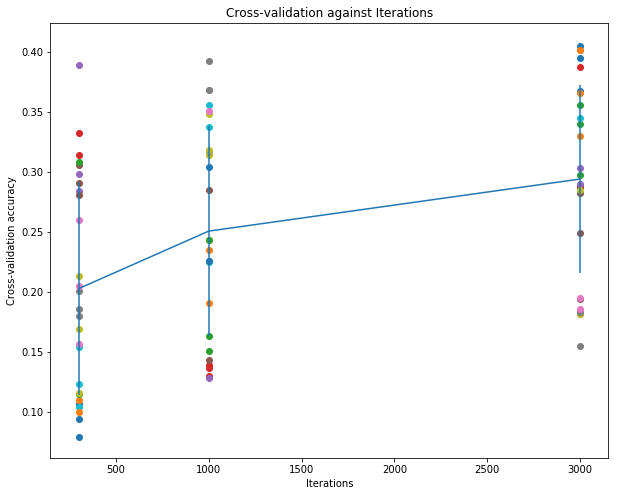

In [29]:
# plot the raw observations

stat = {}

for rate, reg, iters, size in sorted(results):
    
    train_accuracy, val_accuracy = results[(rate, reg, iters, size)]
    
    plt.scatter(iters, val_accuracy)
    
    stat.setdefault(iters, []).append(val_accuracy)
    
# plot the trend line with error bars that correspond to standard deviation

val_accuracy_mean = np.array([np.mean(val_accuracy) for key, val_accuracy in sorted(stat.items())])
val_accuracy_std = np.array([np.std(val_accuracy) for key, val_accuracy in sorted(stat.items())])
plt.errorbar(num_iters, val_accuracy_mean, yerr = val_accuracy_std)
plt.title('Cross-validation against Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cross-validation accuracy')
plt.savefig('iterations.png')
plt.show()

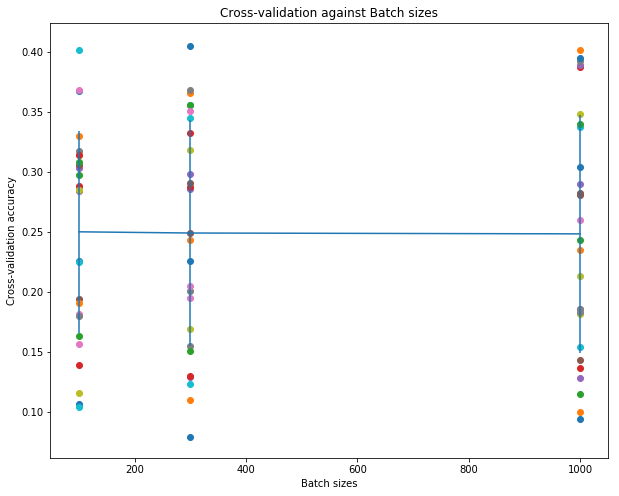

In [30]:
# plot the raw observations

stat = {}

for rate, reg, iters, size in sorted(results):
    
    train_accuracy, val_accuracy = results[(rate, reg, iters, size)]
    
    plt.scatter(size, val_accuracy)
    
    stat.setdefault(size, []).append(val_accuracy)
    
# plot the trend line with error bars that correspond to standard deviation

val_accuracy_mean = np.array([np.mean(val_accuracy) for key, val_accuracy in sorted(stat.items())])
val_accuracy_std = np.array( [ np.std(val_accuracy) for key, val_accuracy in sorted(stat.items())])
plt.errorbar(batch_sizes, val_accuracy_mean, yerr = val_accuracy_std)
plt.title('Cross-validation against Batch sizes')
plt.xlabel('Batch sizes')
plt.ylabel('Cross-validation accuracy')
plt.savefig('batchsizes.png')
plt.show()

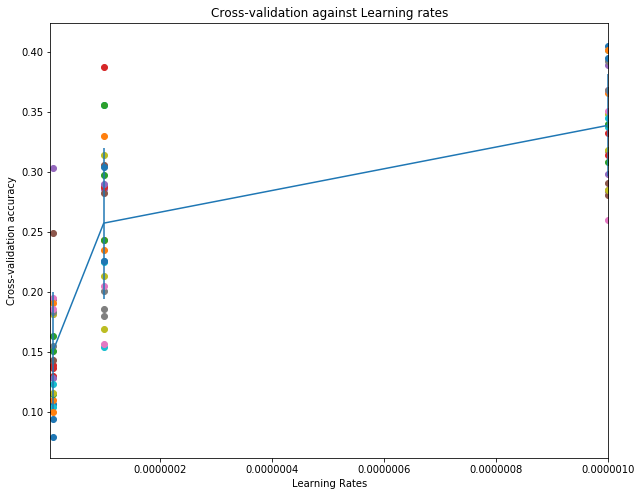

In [31]:
# plot the raw observations

stat = {}

for rate, reg, iters, size in sorted(results):
    
    train_accuracy, val_accuracy = results[(rate, reg, iters, size)]
    
    plt.scatter(rate, val_accuracy)
    
    stat.setdefault(rate, []).append(val_accuracy)
    
# plot the trend line with error bars that correspond to standard deviation

val_accuracy_mean = np.array([np.mean(val_accuracy) for key, val_accuracy in sorted(stat.items())])
val_accuracy_std = np.array([np.std(val_accuracy) for key, val_accuracy in sorted( stat.items())])
plt.errorbar(learning_rates, val_accuracy_mean, yerr = val_accuracy_std)
plt.xlim( [5e-9, 1e-6] )
plt.title('Cross-validation against Learning rates')
plt.xlabel('Learning Rates')
plt.ylabel('Cross-validation accuracy')
plt.savefig('learningrates.png')
plt.show()

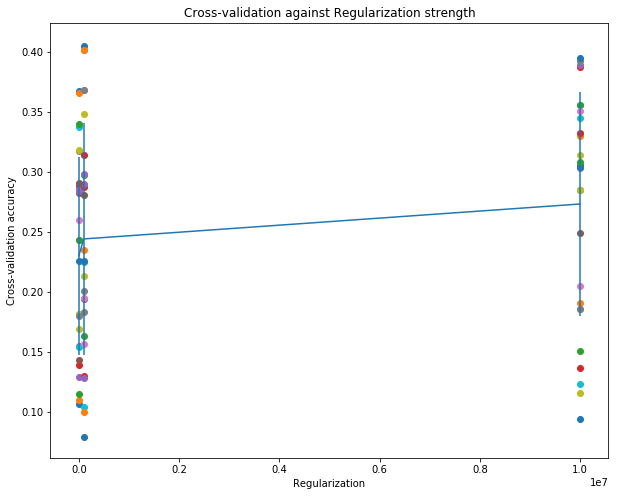

In [32]:
# plot the raw observations

stat = {}

for rate, reg, iters, size in sorted(results):
    
    train_accuracy, val_accuracy = results[(rate, reg, iters, size)]
    
    plt.scatter(reg, val_accuracy)
    
    stat.setdefault(reg, []).append(val_accuracy)
    
# plot the trend line with error bars that correspond to standard deviation

val_accuracy_mean = np.array([np.mean(val_accuracy) for key, val_accuracy in sorted(stat.items())])
val_accuracy_std = np.array([np.std(val_accuracy) for key, val_accuracy in sorted(stat.items())])
plt.errorbar(regularization_strengths, val_accuracy_mean, yerr = val_accuracy_std)
plt.title('Cross-validation against Regularization strength')
plt.xlabel('Regularization')
plt.ylabel('Cross-validation accuracy')
plt.savefig('regularization.png')
plt.show()

In [33]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set and the test set.

import linear_classifier

results = {}
best_val = -1
best_softmax = None
num_iters = 3000
batch_size = 300
learning_rates = [1e-6, 3e-6, 1e-5]
regularization_strengths = [1e5, 1e6, 1e7]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in variable best_softmax.            #
################################################################################

for rate in learning_rates:
    
    for reg in regularization_strengths:
        
        lc_softmax = linear_classifier.LinearClassifier()
        
        lc_softmax.train(X_train, y_train, learning_rate = rate, reg = reg, num_iters = num_iters, batch_size = batch_size, verbose = True)
        
        y_train_pred = lc_softmax.predict(X_train)
        y_val_pred = lc_softmax.predict(X_val)
        
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results.setdefault((rate, reg))
        
        results[(rate, reg)] = train_accuracy, val_accuracy
        
        if val_accuracy > best_val:
        
            best_val = val_accuracy
        
            best_rate, best_reg = rate, reg
            
            best_softmax = lc_softmax

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 3000: loss 10.848979
iteration 100 / 3000: loss 7.433181
iteration 200 / 3000: loss 6.751037
iteration 300 / 3000: loss 6.304355
iteration 400 / 3000: loss 6.057111
iteration 500 / 3000: loss 5.670041
iteration 600 / 3000: loss 5.355650
iteration 700 / 3000: loss 5.049479
iteration 800 / 3000: loss 4.733639
iteration 900 / 3000: loss 4.599380
iteration 1000 / 3000: loss 4.414153
iteration 1100 / 3000: loss 4.216154
iteration 1200 / 3000: loss 3.902829
iteration 1300 / 3000: loss 4.008909
iteration 1400 / 3000: loss 3.699459
iteration 1500 / 3000: loss 3.598478
iteration 1600 / 3000: loss 3.348793
iteration 1700 / 3000: loss 3.352825
iteration 1800 / 3000: loss 3.197755
iteration 1900 / 3000: loss 3.092161
iteration 2000 / 3000: loss 3.009287
iteration 2100 / 3000: loss 2.852810
iteration 2200 / 3000: loss 2.757470
iteration 2300 / 3000: loss 2.770105
iteration 2400 / 3000: loss 2.638196
iteration 2500 / 3000: loss 2.689161
iteration 2600 / 3000: loss 2.638102
iteration 27

iteration 1400 / 3000: loss 4.536753
iteration 1500 / 3000: loss 3.870051
iteration 1600 / 3000: loss 3.043037
iteration 1700 / 3000: loss 3.911210
iteration 1800 / 3000: loss 2.872917
iteration 1900 / 3000: loss 4.354958
iteration 2000 / 3000: loss 2.705590
iteration 2100 / 3000: loss 3.770362
iteration 2200 / 3000: loss 3.677721
iteration 2300 / 3000: loss 3.018804
iteration 2400 / 3000: loss 4.144325
iteration 2500 / 3000: loss 3.559754
iteration 2600 / 3000: loss 4.353591
iteration 2700 / 3000: loss 3.978407
iteration 2800 / 3000: loss 3.442357
iteration 2900 / 3000: loss 2.864153
iteration 0 / 3000: loss 515.922929
iteration 100 / 3000: loss 8.530168
iteration 200 / 3000: loss 5.614545
iteration 300 / 3000: loss 5.782161
iteration 400 / 3000: loss 5.821024
iteration 500 / 3000: loss 6.070034
iteration 600 / 3000: loss 7.945775
iteration 700 / 3000: loss 5.068362
iteration 800 / 3000: loss 6.131424
iteration 900 / 3000: loss 5.379915
iteration 1000 / 3000: loss 5.251646
iteration 1

In [35]:
# Print out results.

for rate, reg in sorted(results):
    
    train_accuracy, val_accuracy = results[(rate, reg)]
    
    print 'iter 3000 size 300 rate %e reg %e train accuracy: %f val accuracy: %f' % (rate, reg, train_accuracy, val_accuracy)
    
print '\nBest validation accuracy achieved during cross-validation is %f by iter 3000 size 300 rate %e reg %e.' % (best_val, rate, reg)


# Evaluate the best softmax classifier on test set

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print '\nSoftmax on raw pixels final test set accuracy: %f.' % test_accuracy

iter 3000 size 300 rate 1.000000e-06 reg 1.000000e+05 train accuracy: 0.412408 val accuracy: 0.390000
iter 3000 size 300 rate 1.000000e-06 reg 1.000000e+06 train accuracy: 0.392857 val accuracy: 0.400000
iter 3000 size 300 rate 1.000000e-06 reg 1.000000e+07 train accuracy: 0.337735 val accuracy: 0.358000
iter 3000 size 300 rate 3.000000e-06 reg 1.000000e+05 train accuracy: 0.412755 val accuracy: 0.387000
iter 3000 size 300 rate 3.000000e-06 reg 1.000000e+06 train accuracy: 0.380918 val accuracy: 0.367000
iter 3000 size 300 rate 3.000000e-06 reg 1.000000e+07 train accuracy: 0.289143 val accuracy: 0.314000
iter 3000 size 300 rate 1.000000e-05 reg 1.000000e+05 train accuracy: 0.300796 val accuracy: 0.304000
iter 3000 size 300 rate 1.000000e-05 reg 1.000000e+06 train accuracy: 0.192592 val accuracy: 0.205000
iter 3000 size 300 rate 1.000000e-05 reg 1.000000e+07 train accuracy: 0.190837 val accuracy: 0.198000

Best validation accuracy achieved during cross-validation is 0.400000 by iter 300